In [1]:
from pathlib import Path

from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
# define constants

DATA = Path.home() / 'devel/motiondetection'
DATA_ROOT = DATA / 'data'


In [3]:
print(DATA_ROOT)

/home/michele/devel/motiondetection/data


### Load data

**Data description**
- Column 1: Time in seconds
- Column 2: Acceleration reading in G for frontal axis
- Column 3: Acceleration reading in G for vertical axis
- Column 4: Acceleration reading in G for lateral axis
- Column 5: Id of antenna reading sensor
- Column 6: Received signal strength indicator (RSSI)
- Column 7: Phase
- Column 8: Frequency
- Column 9: Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating

In [4]:
dfs = []
activities = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in DATA_ROOT.rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activities[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    dfs.append(df)

activity_df = pd.concat(dfs, axis='index')
# activity_df.to_csv('activity_df.csv')

In [5]:
activity_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
0,0.000,0.037521,0.91636,-0.367180,2,-47.0,4.401000,923.25,4,ambulating,F,d1p26F
1,0.025,0.037521,0.91636,-0.367180,2,-47.0,4.158600,923.25,4,ambulating,F,d1p26F
2,0.075,0.037521,0.91636,-0.367180,2,-48.0,0.072097,923.25,4,ambulating,F,d1p26F
3,0.100,0.236850,1.05420,0.168760,2,-48.0,1.998800,923.25,4,ambulating,F,d1p26F
4,0.500,0.049247,1.00820,0.088944,2,-58.0,1.572300,921.25,4,ambulating,F,d1p26F


In [ ]:
len(activity_df.participant.unique())

In [ ]:
participant = 'd1p44M'
df = activity_df[activity_df['participant'] == participant]
df.head()

In [ ]:
part = df['participant'].unique()[0]

fig, ax = plt.subplots()
ax.plot(df['front'], color='aqua')
ax.plot(df['vertical'], color='blue')
ax.plot(df['lateral'], color='lime')
ax.set_title(part)

fig.savefig('{}.png'.format(part))


#### hmm it looks like some of the participants' data is very sparse. better get an indication of data points for each participant

In [ ]:
data_points = activity_df.groupby('participant').size()

In [ ]:
data_points.min()

In [ ]:
len(data_points[data_points < 100])

### let's plot the figure without lables for all the participants!

In [10]:
def plotter(name, group):
    fig, ax = plt.subplots()
    ax.plot(group['front'], color='aqua')
    ax.plot(group['vertical'], color='blue')
    ax.plot(group['lateral'], color='lime')
    ax.set_title(name)
    fig.savefig('{}.png'.format(name))
    plt.close(fig)

In [11]:
for name, group in activity_df.groupby('participant'):
    plotter(name, group)

### much neater way of creating gif from multiple plots:

(cheers Mark ;)

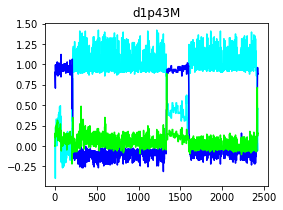

In [13]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4, 3))
names = activity_df['participant'].unique()
    
def plotter(i):
    plt.cla()
    group = activity_df[activity_df['participant'] == names[i]]
    ax.plot(group['front'], color='aqua')
    ax.plot(group['vertical'], color='blue')
    ax.plot(group['lateral'], color='lime')
    ax.set_title(names[i])

anim = FuncAnimation(fig, plotter, frames=np.arange(0, len(names)), interval=1000)
anim.save('plots.gif', dpi=150, writer='pillow')

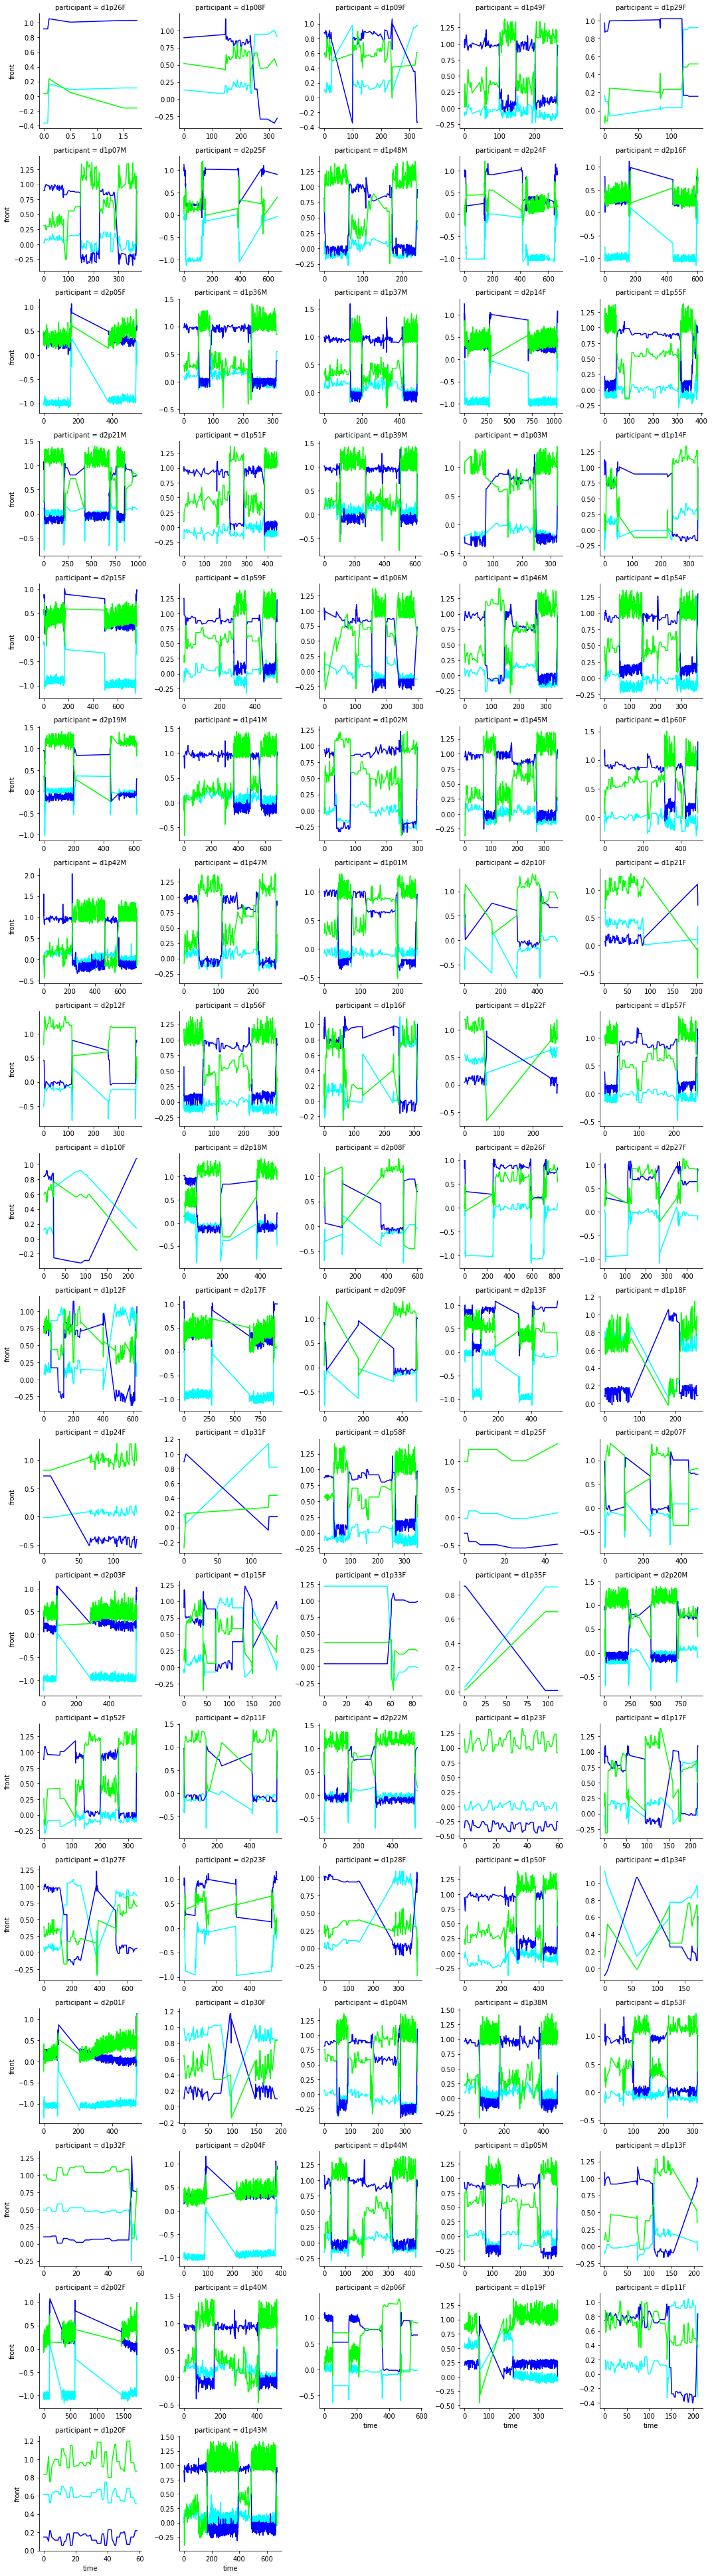

In [14]:
import seaborn as sns

g = sns.FacetGrid(activity_df, col='participant', col_wrap=5, sharex=False, sharey=False)
def plotter(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)
g.map_dataframe(plotter, 'time', 'lateral', color='aqua')
g.map_dataframe(plotter, 'time', 'vertical', color='blue')
g.map_dataframe(plotter, 'time', 'front', color='lime')